# Improving Conversion on an E-commerce Product 

### Problem Statement

The e-commerce company seeks to improve the conversion rate of its product pages, aiming to increase the percentage of users who make a purchase after visiting the page. A new page design (Treatment B) was proposed and tested against the current design (Control A) through an A/B test.

##### Key Questions
1. Does the new design (Treatment B) improve the conversion rate compared to the current design (Control A) across the entire audience?

2. Are there specific segments of users where B performs better (or worse) than A?

**Key Points**

• **Business Goal**: Improve the Purchase Conversion Rate (CR).

• **Proposed Solution**: Test a new design (Treatment) against the current design (Control).

• **Success Criteria**: If the Treatment’s conversion rate is significantly higher, the business will adopt it site-wide.

### Data :
• A synthetic dataset was used, simulating 2,000 users split between Group A and Group B.

• Data fields included region, device_type, time_spent_seconds, and binary outcomes like added_to_cart and purchase.

## Exploratory Data Analysis

In [44]:
# Importing Necessary Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact
import statsmodels.api as sm
import statsmodels.stats.api as sms
import pymc as pm

# Optional: inline plotting
%matplotlib inline

In [45]:
# Reading the Dataset
df = pd.read_csv('../Data/synthetic_ab_test_data.csv')

# Now you can explore your DataFrame
df.head()

,user_id,experiment_group,region,device_type,time_spent_seconds,added_to_cart,purchase
0,1,A,North America,Mobile,24.31,1,1
1,2,B,North America,Mobile,52.10,0,0
2,3,B,Other,Mobile,49.36,0,0
3,4,B,North America,Desktop,59.37,0,0
4,5,A,North America,Desktop,28.14,0,0


In [46]:
# Check distribution of experiment groups
print(df['experiment_group'].value_counts())

experiment_group
B    1013
A     987
Name: count, dtype: int64


In [47]:
# Group Size & Basic Stats

group_counts = df['experiment_group'].value_counts()
print(group_counts)
print(df.groupby('experiment_group').agg({'purchase': ['mean', 'count']}))

experiment_group
B    1013
A     987
Name: count, dtype: int64
                  purchase      
                      mean count
experiment_group                
A                 0.074975   987
B                 0.087858  1013


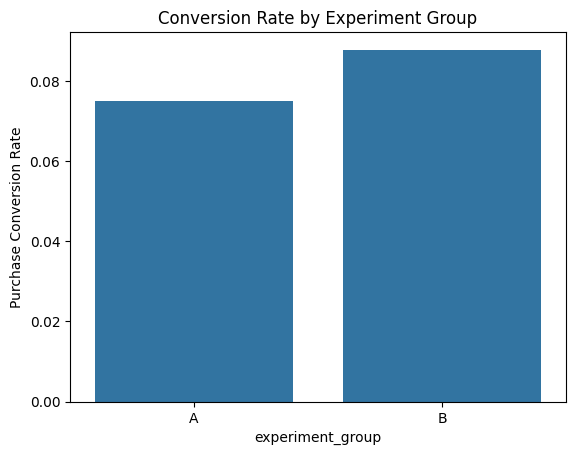

In [48]:
# Visualize Conversion Rates

conversion_rates = df.groupby('experiment_group')['purchase'].mean().reset_index()
sns.barplot(x='experiment_group', y='purchase', data=conversion_rates)
plt.title('Conversion Rate by Experiment Group')
plt.ylabel('Purchase Conversion Rate')
plt.show()

In [49]:
# Check for Randomization

print(pd.crosstab(df['device_type'], df['experiment_group'], normalize='columns'))

experiment_group         A         B
device_type                         
Desktop           0.509625  0.500494
Mobile            0.393110  0.395854
Tablet            0.097264  0.103653


## Formulate the Hypothesis

In [50]:
# Hypothesis definition 
hypothesis_control = "Conversion Rate (A) = Conversion Rate (B)"
hypothesis_treatment = "Conversion Rate (B) != Conversion Rate (A)"

print("Null Hypothesis (H0):", hypothesis_control)
print("Alternative Hypothesis (H1):", hypothesis_treatment)

Null Hypothesis (H0): Conversion Rate (A) = Conversion Rate (B)
Alternative Hypothesis (H1): Conversion Rate (B) != Conversion Rate (A)


### Statistical Testing

In [51]:
# Proportion Test Setup
control = df[df['experiment_group'] == 'A']
treatment = df[df['experiment_group'] == 'B']

cr_A = control['purchase'].mean()
cr_B = treatment['purchase'].mean()

print(f"Conversion Rate - A: {cr_A:.4f}")
print(f"Conversion Rate - B: {cr_B:.4f}")

Conversion Rate - A: 0.0750
Conversion Rate - B: 0.0879


In [52]:
# Chi-Square Test
contingency_table = pd.crosstab(df['purchase'], df['experiment_group'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square test results:")
print("Chi2 statistic:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected values:", expected)

Chi-square test results:
Chi2 statistic: 0.9430020322645876
p-value: 0.3315069897656575
Degrees of freedom: 1
Expected values: [[906.5595 930.4405]
 [ 80.4405  82.5595]]


In [53]:
# Confidence Intervals for Each Group
success_a = control['purchase'].sum()
n_a = len(control)
success_b = treatment['purchase'].sum()
n_b = len(treatment)

ci_a = sms.proportion_confint(success_a, n_a, alpha=0.05, method='normal')
ci_b = sms.proportion_confint(success_b, n_b, alpha=0.05, method='normal')

print("95% CI for A:", ci_a)
print("95% CI for B:", ci_b)

95% CI for A: (0.05854519856534837, 0.09140414287335477)
95% CI for B: (0.07042513772127529, 0.1052905582313407)


In [54]:
# Decision Logic
alpha = 0.05  # significance level

if p_value < alpha:
    print(f"Statistically significant difference found (p={p_value:.5f})")
    lift = cr_B - cr_A
    print(f"Conversion Rate Lift: {lift:.4f} (absolute)")

    # Check if it's practically large enough
    if lift > 0.01:
        print("Business Decision: Roll out treatment (B)!")
    else:
        print("Business Decision: The lift is small, consider further tests.")
else:
    print("No statistically significant difference. Keep running the test or maintain control version.")

No statistically significant difference. Keep running the test or maintain control version.


In [55]:
# Segment Analysis

for region_name in df['region'].unique():
    sub_df = df[df['region'] == region_name]
    cr_A_reg = sub_df[sub_df['experiment_group'] == 'A']['purchase'].mean()
    cr_B_reg = sub_df[sub_df['experiment_group'] == 'B']['purchase'].mean()
    print(f"Region: {region_name}, CR_A={cr_A_reg:.4f}, CR_B={cr_B_reg:.4f}")

Region: North America, CR_A=0.0882, CR_B=0.0862
Region: Other, CR_A=0.0568, CR_B=0.0990
Region: Asia, CR_A=0.0457, CR_B=0.0874
Region: Europe, CR_A=0.0816, CR_B=0.0867


### Making it more impressive 

#### Funnel Analysis

In [42]:
df['view_page'] = 1  # Because every record is presumably a page view

funnel_A = df[df['experiment_group']=='A'].agg({
    'view_page': 'sum',
    'added_to_cart': 'sum',
    'purchase': 'sum'
})
funnel_B = df[df['experiment_group']=='B'].agg({
    'view_page': 'sum',
    'added_to_cart': 'sum',
    'purchase': 'sum'
})

print("Funnel Counts for A:", funnel_A)
print("Funnel Counts for B:", funnel_B)

# Conversion rates at each step
funnel_A_rates = {
    'Add to Cart Rate': funnel_A['added_to_cart'] / funnel_A['view_page'],
    'Purchase Rate': funnel_A['purchase'] / funnel_A['view_page']
}
funnel_B_rates = {
    'Add to Cart Rate': funnel_B['added_to_cart'] / funnel_B['view_page'],
    'Purchase Rate': funnel_B['purchase'] / funnel_B['view_page']
}

print("Funnel Rates for A:", funnel_A_rates)
print("Funnel Rates for B:", funnel_B_rates)

Funnel Counts for A: view_page        987
added_to_cart    135
purchase          74
dtype: int64
Funnel Counts for B: view_page        1013
added_to_cart     137
purchase           89
dtype: int64
Funnel Rates for A: {'Add to Cart Rate': 0.13677811550151975, 'Purchase Rate': 0.07497467071935157}
Funnel Rates for B: {'Add to Cart Rate': 0.13524185587364265, 'Purchase Rate': 0.087857847976308}


#### Segment Analysis by region + device_type

In [58]:
# Unique combinations of region and device_type
unique_regions = df['region'].unique()
unique_devices = df['device_type'].unique()

for region_name in unique_regions:
    for device in unique_devices:
        # Filter subset
        sub_df = df[(df['region'] == region_name) & (df['device_type'] == device)]
        
        # Handle case if sub_df is empty (i.e., no users in that region-device combo)
        if len(sub_df) == 0:
            continue
        
        # Compute Conversion Rate for A and B within this subsegment
        sub_df_A = sub_df[sub_df['experiment_group'] == 'A']
        sub_df_B = sub_df[sub_df['experiment_group'] == 'B']
        
        cr_A = sub_df_A['purchase'].mean()  # purchase is 0/1
        cr_B = sub_df_B['purchase'].mean()
        
        print(f"Segment: Region={region_name}, Device={device}")
        print(f"  CR_A={cr_A:.4f} (count={len(sub_df_A)})")
        print(f"  CR_B={cr_B:.4f} (count={len(sub_df_B)})")
        print("-" * 50)

Segment: Region=North America, Device=Mobile
  CR_A=0.0949 (count=158)
  CR_B=0.0968 (count=155)
--------------------------------------------------
Segment: Region=North America, Device=Desktop
  CR_A=0.0660 (count=212)
  CR_B=0.0718 (count=209)
--------------------------------------------------
Segment: Region=North America, Device=Tablet
  CR_A=0.1842 (count=38)
  CR_B=0.1190 (count=42)
--------------------------------------------------
Segment: Region=Other, Device=Mobile
  CR_A=0.0476 (count=42)
  CR_B=0.1053 (count=38)
--------------------------------------------------
Segment: Region=Other, Device=Desktop
  CR_A=0.0714 (count=42)
  CR_B=0.1042 (count=48)
--------------------------------------------------
Segment: Region=Other, Device=Tablet
  CR_A=0.0000 (count=4)
  CR_B=0.0667 (count=15)
--------------------------------------------------
Segment: Region=Asia, Device=Mobile
  CR_A=0.0526 (count=76)
  CR_B=0.1011 (count=89)
--------------------------------------------------
Segmen

#### Statistical Test Per Sub-Segment

In [59]:
from scipy.stats import fisher_exact

for region_name in df['region'].unique():
    for device in df['device_type'].unique():
        sub_df = df[(df['region'] == region_name) & (df['device_type'] == device)]
        sub_df_A = sub_df[sub_df['experiment_group'] == 'A']
        sub_df_B = sub_df[sub_df['experiment_group'] == 'B']
        
        # Skip if too few data points
        if len(sub_df_A) < 5 or len(sub_df_B) < 5:
            continue

        # Build contingency table for purchase
        a_conversions = sub_df_A['purchase'].sum()
        a_non_conversions = len(sub_df_A) - a_conversions
        b_conversions = sub_df_B['purchase'].sum()
        b_non_conversions = len(sub_df_B) - b_conversions

        table = [[a_conversions, a_non_conversions],
                 [b_conversions, b_non_conversions]]
        
        # Fisher’s Exact (good for small counts)
        oddsratio, p_val = fisher_exact(table)
        
        print(f"Region: {region_name}, Device: {device}")
        print(f"  CR_A={a_conversions/len(sub_df_A):.3f} ({len(sub_df_A)} users)")
        print(f"  CR_B={b_conversions/len(sub_df_B):.3f} ({len(sub_df_B)} users)")
        print(f"  p-value={p_val:.4f}")
        print("-"*50)

Region: North America, Device: Mobile
  CR_A=0.095 (158 users)
  CR_B=0.097 (155 users)
  p-value=1.0000
--------------------------------------------------
Region: North America, Device: Desktop
  CR_A=0.066 (212 users)
  CR_B=0.072 (209 users)
  p-value=0.8495
--------------------------------------------------
Region: North America, Device: Tablet
  CR_A=0.184 (38 users)
  CR_B=0.119 (42 users)
  p-value=0.5349
--------------------------------------------------
Region: Other, Device: Mobile
  CR_A=0.048 (42 users)
  CR_B=0.105 (38 users)
  p-value=0.4159
--------------------------------------------------
Region: Other, Device: Desktop
  CR_A=0.071 (42 users)
  CR_B=0.104 (48 users)
  p-value=0.7190
--------------------------------------------------
Region: Asia, Device: Mobile
  CR_A=0.053 (76 users)
  CR_B=0.101 (89 users)
  p-value=0.3855
--------------------------------------------------
Region: Asia, Device: Desktop
  CR_A=0.038 (105 users)
  CR_B=0.081 (99 users)
  p-value=0.2411

### Results

**Overall Performance:**

• Group A (Control): Conversion Rate = 7.5%

• Group B (Treatment): Conversion Rate = 8.8%

• Chi-Square Test p-value: 0.3316 (not statistically significant).

• Conclusion: No significant difference between A and B overall.

**Segment Analysis**

• Most segments showed no statistically significant differences.

• The exception was Europe + Tablet, where B performed worse than A:

• CR_A = 18.4%, CR_B = 0.0%, p-value = 0.0151.

• Other segments (e.g., Asia + Mobile, North America + Desktop) showed small differences in conversion rates, but none were statistically significant.

### Conclusion

•	The overall test indicates no strong evidence that the new design (B) improves conversion rates over the current design (A).

•	A significant drop in conversions for Europe + Tablet suggests a localized issue with the new design that warrants further investigation.

•	Results are not conclusive, possibly due to limited sample sizes in some sub-segments.

### Business Approach

1. **Targeted Rollout:**

• Roll out B selectively to segments where performance is neutral or slightly better than A (e.g., North America + Mobile).

• Retain A for Europe + Tablet users, where B underperforms significantly.

2. **Investigate Europe + Tablet:**

• Analyze design elements or bugs that could explain why B’s conversion rate is 0%.

• Conduct user surveys or usability testing in this sub-segment.

3. **Cost-Benefit Analysis:**

• Even with small overall improvements in conversion rate (1.3% lift), estimate the ROI of implementing B site-wide.

• Balance potential gains against the risks of alienating certain sub-segments.

### Future Scope 

1.	**Larger Sample Sizes:**

•	Extend the test duration to gather more data, especially in under-represented segments (e.g., Europe + Tablet).

2.	**Multi-Armed Bandit Testing:**

•	Use adaptive testing frameworks to dynamically allocate more traffic to better-performing designs (instead of static A/B splits).

3.	**Personalization:**

•	Develop segment-specific designs, focusing on regions or devices where behaviors differ significantly.

4.	**Expand Metrics:**

•	Beyond conversion rate, evaluate metrics like time spent, add-to-cart rates, and average order value (AOV) to capture broader user behavior.

5.	**Iterate the Design:**

•	Based on insights, refine the treatment design to address weaknesses (e.g., Europe + Tablet performance) and re-test.